# Introduction to Fourier Neural Operator
by Shrisharanyan Vasu, Bharath Ramsundar

In this tutorial, we will explore what FNOs are how to train them for learning a solution operator for the 2D Heat Equation using DeepChem.

Traditional neural networks, like CNNs and RNNs, are designed to work with fixed-size inputs such as images or sequences, which are essentially just long lists of numbers. Because of this, they struggle when trying to learn solutions to partial differential equations (PDEs), which involve functions defined over continuous spaces (like time or space) and can vary in resolution or size. Neural Operators are a new kind of neural network designed to handle this challenge. Instead of learning mappings between fixed-length vectors, they learn mappings between entire functions, making them much better suited for solving PDEs, even when the input data comes in different sizes or resolutions.

The FNO takes this idea further by using the Fourier transform, a mathematical tool that allows the model to understand patterns in the input on a global scale. This helps the model capture long-range interactions and spatial dependencies more effectively. FNO is particularly powerful for solving PDEs because, in many real-world situations, the important behavior of a solution can be described using just a few key patterns or frequencies. By focusing on those and ignoring the noisy, less important details, FNO learns faster and generalises better.

 
# ![FNO Architecture](./assets/fno_architecture.png)
Image from the official paper: https://arxiv.org/pdf/2010.08895


## Mathematical Formulation
 
The key idea behind FNOs is to project input data into the Fourier domain, apply learnable transformations to a selected number of Fourier modes, and then transform the result back to the spatial domain. This enables the model to learn global operators with fewer parameters and improved generalization compared to standard convolutional neural networks.
 
Given an input function \( u(x) \), the FNO layer operates as follows:

1. **Fourier Transform:**  
   Compute the Fourier transform of the input function $u(x)$:  
   $\hat{u}(k) = \mathcal{F}[u](k) = \int u(x) \exp(-2\pi i k x) dx$

2. **Spectral Convolution:**  
   In the Fourier domain, apply a learnable linear transformation to the first $m$ modes:  
   For $|k| < m$:   $\hat{v}(k) = W(k) \cdot \hat{u}(k)$  
   For $|k| \geq m$:   $\hat{v}(k) = 0$  
   (Here, $W(k)$ are learnable weights for each mode.)

3. **Inverse Fourier Transform:**  
   Transform back to the spatial domain:  
   $v(x) = \mathcal{F}^{-1}[\hat{v}](x) = \sum_k \hat{v}(k) \exp(2\pi i k x)$

4. **Nonlinearity and Stacking:** The output is typically combined with a local (pointwise) neural network and passed through a nonlinearity, and multiple such layers are stacked to form the full FNO.


## Reference

FNOs were introduced by Zongyi Li, Nikola Kovachki, Kamyar Azizzadenesheli, Burigede Liu, Kaushik Bhattacharya, Andrew Stuart, and Anima Anandkumar in their seminal paper:

Li, Zongyi, et al. "Fourier neural operator for parametric partial differential equations." *arXiv preprint arXiv:2010.08895* (2020).


## Colab
This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_To_Fourier_Neural_Operator.ipynb)


# Imports

In [1]:
%pip install -qU deepchem --pre

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import deepchem as dc
from deepchem.data import NumpyDataset
from deepchem.models.torch_models import FNOModel

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/home/spellsharp/Applications/miniconda/miniconda3/envs/deepchem_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped l

# Synthetic Dataset

### Heat Kernel Dataset

This section demonstrates how to generate a synthetic dataset of PDE fields, serving as a stand-in for a real PDE dataset. Since this is only for illustrative purposes, you may skip this section if desired.

The below code generates synthetic data for the 2D heat equation, but instead of numerically solving the PDE step by step, it uses the fact that the solution is known in closed form.

For the heat equation  
$u_t = \alpha \Delta u$  
with initial condition $u_0(x,y)$, the solution at time $T$ is given by convolution with the **heat kernel**:  
$u(x,y,T) = (G_T * u_0)(x,y)$  

Here $G_T$ is a Gaussian with variance $2\alpha T$. In practice, this means the heat equation is exactly equivalent to blurring the initial condition with a Gaussian filter of width  
$\sigma = \sqrt{2\alpha T}$.

The code does exactly this:  
- Generate a random initial field $u_0$ (noise + Gaussian blobs)  
- Apply a Gaussian filter with the correct width to get $u_T$  

The dataset pairs $(u_0, u_T)$ represent the state of a system before and after diffusion, providing input–output examples of the heat equation’s dynamics with periodic boundaries.

References:
1. Wikipedia page on Heat Kernel: https://en.wikipedia.org/wiki/Heat_kernel
2. McMaster University lecture notes: https://ms.mcmaster.ca/craig/craig-pde-chap3.pdf
3. L.C. Evans, Partial Differential Equations, 2nd ed., Graduate Studies in Mathematics, vol. 19, American Mathematical Society, 2010. (see Chapter 2, The Heat Equation)

In [3]:
from scipy.ndimage import gaussian_filter

def generate_heat_dataset_heatkernel(n_samples=2000, nx=128, ny=128, alpha=0.2, T=0.5, seed=42):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, nx, dtype=np.float32)
    y = np.linspace(0, 1, ny, dtype=np.float32)
    X, Y = np.meshgrid(x, y, indexing='ij')
    dx = 1.0 / (nx - 1)
    sigma_phys = np.sqrt(2.0 * alpha * T)
    sigma_px = float(sigma_phys / dx)

    inputs_raw = np.empty((n_samples, 1, nx, ny), dtype=np.float32)
    outputs = np.empty((n_samples, 1, nx, ny), dtype=np.float32)

    for i in range(n_samples):
        u0 = rng.normal(0.0, 0.05, size=(nx, ny)).astype(np.float32)
        if rng.random() > 0.3:
            k = rng.integers(1, 4)
            for _ in range(k):
                cx, cy = rng.random(2)
                sigma0 = rng.uniform(0.06, 0.15)
                amp = rng.uniform(0.5, 2.0)
                u0 += amp * np.exp(-((X-cx)**2 + (Y-cy)**2) / (2*sigma0**2)).astype(np.float32)
        uT = gaussian_filter(u0, sigma=sigma_px, mode='nearest').astype(np.float32)
        inputs_raw[i, 0] = u0
        outputs[i, 0] = uT
    return inputs_raw, outputs

inputs_raw, outputs = generate_heat_dataset_heatkernel()
print(inputs_raw.shape, outputs.shape)

(2000, 1, 128, 128) (2000, 1, 128, 128)


### Creating meshgrids

Meshgrids are a fundamental tool in scientific computing, especially when working with data defined over spatial domains. In two or more dimensions, a meshgrid provides a structured way to represent the coordinates of every point on a grid. For example, in a 2D domain, a meshgrid generates two arrays: one for the x-coordinates and one for the y-coordinates, such that each pair (x, y) corresponds to a unique point on the grid.

Including meshgrid coordinates as part of the input to a neural operator model, such as the Fourier Neural Operator (FNO), is crucial for several reasons:

- **Spatial Awareness:** By providing the (x, y) coordinates for each grid point, the model can learn how the solution depends not just on the input field values but also on their spatial location. This is especially important for problems where the solution varies across space.

- **Generalization:** Meshgrid coordinates help the model generalize to different grid sizes or domains, since the model learns the relationship between the coordinates and the function values, rather than memorizing a fixed grid.

- **Boundary Conditions and Geometry:** For problems with non-trivial geometries or boundary conditions, meshgrids allow the model to be aware of the spatial structure and boundaries of the domain.

In this tutorial, meshgrids are used to generate the x and y coordinate arrays for each point in the 2D grid. These coordinates are then concatenated with the input data and provided to the FNO model, enabling it to learn mappings between functions defined on spatial domains with full knowledge of the underlying geometry.



In [4]:
N, _, nx, ny = inputs_raw.shape
x = np.linspace(0, 1, nx, dtype=np.float32)
y = np.linspace(0, 1, ny, dtype=np.float32)
Xg, Yg = np.meshgrid(x, y, indexing='ij')
Xb = np.broadcast_to(Xg, (N, 1, nx, ny)).astype(np.float32)
Yb = np.broadcast_to(Yg, (N, 1, nx, ny)).astype(np.float32)

x_inputs = np.concatenate([inputs_raw, Xb, Yb], axis=1)
y_targets = outputs

n_train = int(0.9*N)
x_train, x_test = x_inputs[:n_train], x_inputs[n_train:]
y_train, y_test = y_targets[:n_train], y_targets[n_train:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1800, 3, 128, 128),
 (1800, 1, 128, 128),
 (200, 3, 128, 128),
 (200, 1, 128, 128))

DeepChem's TorchModel subclasses work with `NumpyDataset` the best. The below code snippet creates two `NumpyDataset` instances of the generated dataset, one for training and another for testing.

In [5]:
train_ds = NumpyDataset(X=x_train.astype(np.float32), y=y_train.astype(np.float32))
test_ds  = NumpyDataset(X=x_test.astype(np.float32),  y=y_test.astype(np.float32))

# Training FNOModel

### Initializing device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Initializing the FNOModel

The `FNOModel` class extends DeepChem's `TorchModel` and introduces several parameters specific to Fourier Neural Operators:
- `modes`: Number of Fourier modes to keep in the spectral convolution. Higher values allow the model to capture more high-frequency information, but increase computational cost. For 2D problems, this can be an integer or a tuple specifying the number of modes in each spatial dimension.
- `width`: The number of channels/features in the hidden layers of the FNO blocks. Controls the model's capacity.
- `dims`: The spatial dimensionality of the input data (e.g., 1 for 1D, 2 for 2D, 3 for 3D problems). This determines how many spatial axes the model expects.
- `depth`: Number of FNO blocks to stack. More blocks can help the model learn more complex mappings.
- `positional_encoding`: If `True`, the model automatically appends meshgrid-based positional encodings (coordinates) to the input, allowing the FNO to be aware of the spatial structure and geometry of the domain. If you provide your own positional encodings, set this to `False`.

In [7]:
model = FNOModel(
    in_channels=3,
    out_channels=1,
    batch_size=16, # May need to change based on available GPU VRAM
    modes=36, 
    width=96, 
    dims=2, 
    depth=4,
    positional_encoding=False, # Set to False, since we provided our own positional encodings
    device=device
)
losses = []
loss = model.fit(train_ds, nb_epoch=10, all_losses=losses)

/home/spellsharp/Applications/miniconda/miniconda3/envs/deepchem_env/lib/python3.10/site-packages/deepchem/models/torch_models/torch_model.py:455: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  avg_loss = float(avg_loss) / averaged_batches


In [8]:
print("Training MSE: ", loss)

Training MSE:  0.00022143148817121983


### Loss Curve

Let us plot the loss curve to understand how the model trained over the epochs.

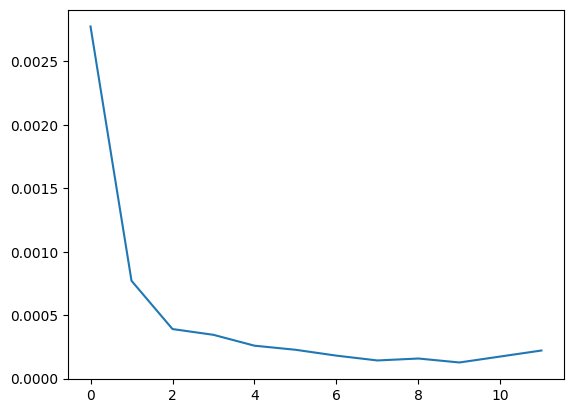

In [9]:
plt.plot(losses)
plt.show()

# Evaluation

In this section, we will evaluate the performance of our trained FNOModel on the test dataset.
We will use standard regression metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE)
to quantify how well the model predicts the solution fields. Lower values of these metrics indicate
better predictive accuracy.


In [10]:
y_pred = model.predict(test_ds)
err = y_pred - y_test

mse = np.mean((err**2))
mae  = np.mean(np.abs(err))

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

Test MSE: 0.00020522291015367955
Test MAE: 0.009664651937782764


Although the MAE may appear quite good, it should be interpreted relative to solver standards rather than typical neural network benchmarks. For numerical solvers, an error tolerance of 1e-5 is the expected standard.

# Benchmarking

Let us compare our FNOModel's performance with a traditional solver. We will use a python library for this task.

We use FiPy (https://www.ctcms.nist.gov/fipy/), a Python library for solving PDEs with the finite-volume method.  
The code below sets up a 2-D diffusion problem on a uniform grid with zero-flux (Neumann) boundaries and evolves each chosen initial condition forward in time. The helper function runs the solver for a subset of samples and returns the final states so we can compare them directly to the model predictions.


In [11]:
from fipy import CellVariable, Grid2D, TransientTerm, DiffusionTerm

def fipy_heat_batch(u0_batch, alpha=0.2, T=0.5, nsteps=12, sel=None):
    N, nx, ny = u0_batch.shape
    if sel is None:
        sel = np.arange(N)

    dt = T / nsteps
    mesh = Grid2D(dx=1.0/(nx-1), dy=1.0/(ny-1), nx=nx, ny=ny)
    u = CellVariable(mesh=mesh, value=0.0)
    eq = TransientTerm() == DiffusionTerm(coeff=alpha)

    out = np.full((N, 1, nx, ny), np.nan, dtype=np.float32)
    for idx in sel:
        u.setValue(u0_batch[idx].ravel(order='F'))
        for _ in range(nsteps):
            eq.solve(var=u, dt=dt)
        out[idx, 0] = np.array(u.value, dtype=np.float32).reshape(nx, ny, order='F')
    return out

# Run on a small subset for speed (e.g. top-16 energetic samples)
subset = np.argsort(- np.sqrt(np.sum(y_test**2,(1,2,3))))[:16]
u0_test = x_test[:, 0]
cn_out = fipy_heat_batch(u0_test, alpha=0.2, T=0.5, nsteps=12, sel=subset)


# Visualization

In this section, we will visualize the predictions of our trained FNO model.
We will compare the model's predicted solutions to the ground truth for selected test samples.
This qualitative analysis helps us understand how well the model captures the underlying patterns
and where it might struggle. We will focus on samples with the highest energy to highlight challenging cases.


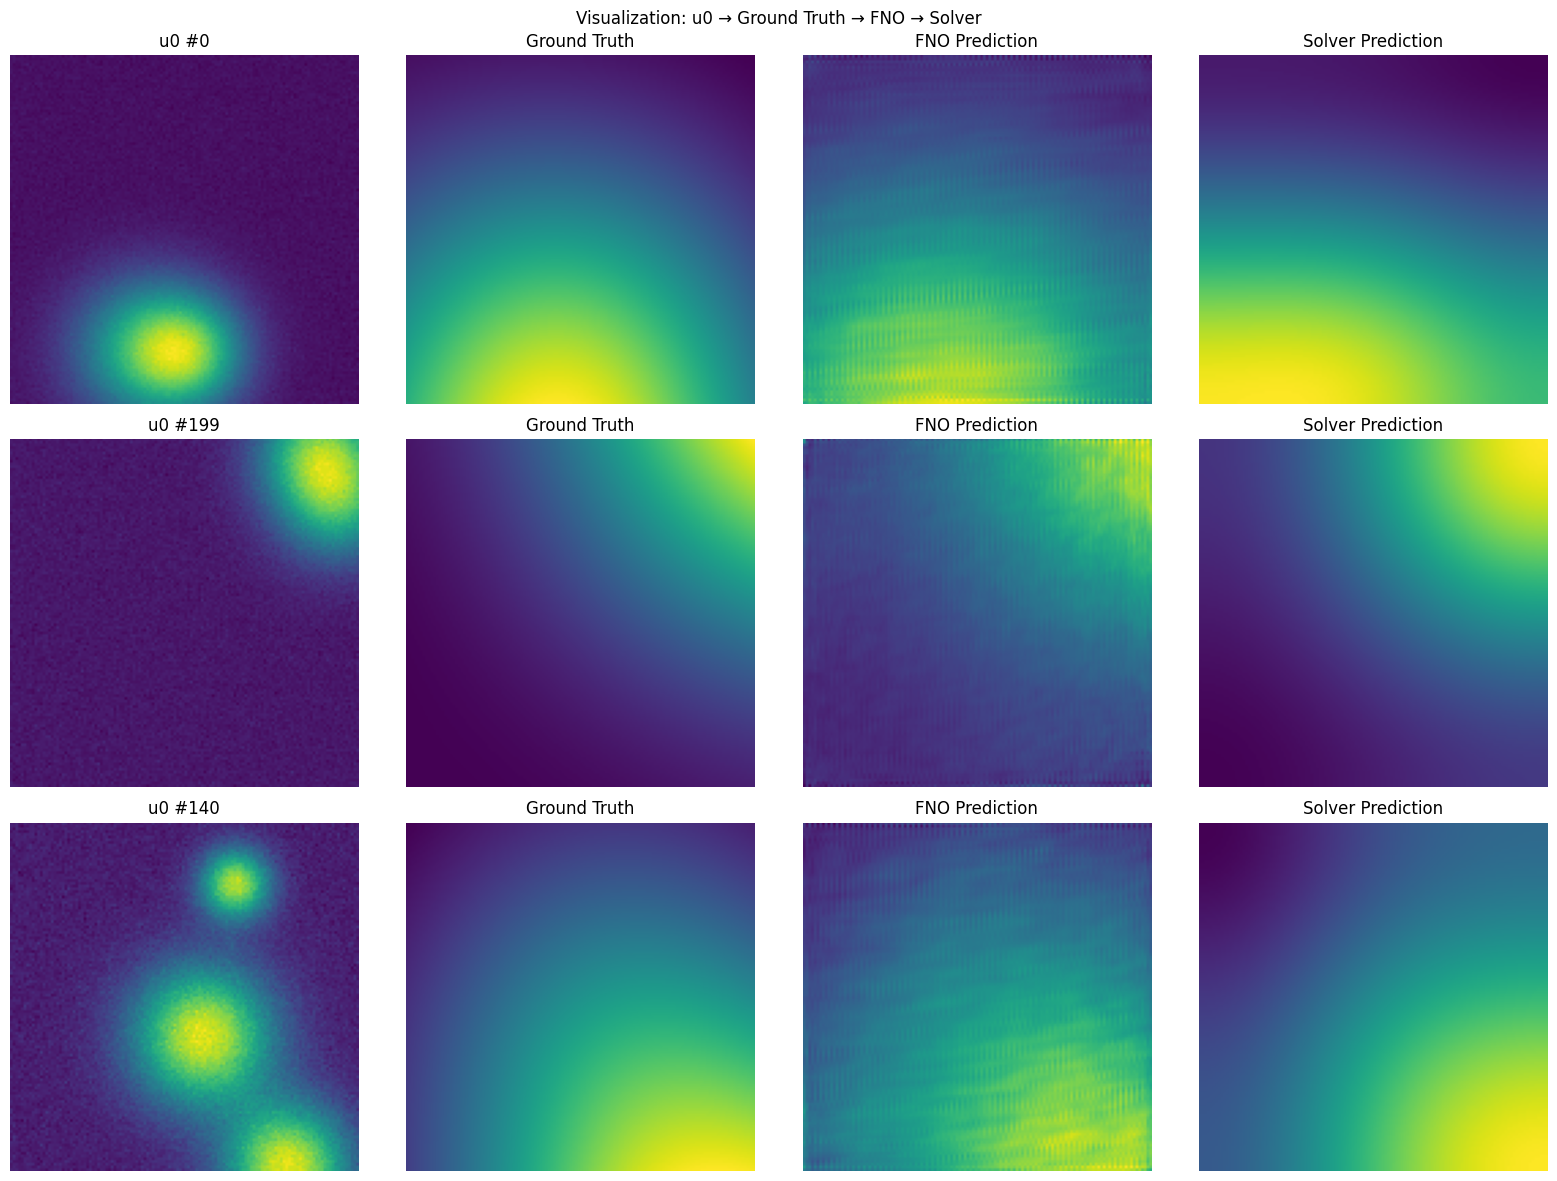

In [12]:
idxs = np.argsort(- np.sqrt(np.sum(y_test**2,(1,2,3))))

k = min(3, len(idxs))
fig, ax = plt.subplots(k, 4, figsize=(16, 4*k))  # k rows, 4 columns

for r, i in enumerate(idxs[:k]):
    ax[r,0].imshow(x_test[i,0]); ax[r,0].set_title(f'u0 #{i}'); ax[r,0].axis('off')
    ax[r,1].imshow(y_test[i,0]); ax[r,1].set_title('Ground Truth'); ax[r,1].axis('off')
    ax[r,2].imshow(y_pred[i,0]); ax[r,2].set_title('FNO Prediction'); ax[r,2].axis('off')
    ax[r,3].imshow(cn_out[i,0]); ax[r,3].set_title('Solver Prediction');ax[r,3].axis('off')

fig.suptitle("Visualization: u0 → Ground Truth → FNO → Solver")
plt.tight_layout()
plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!